<a id="0"></a> <br>
# Airline Passenger Satisfaction

__Dataset Source:__ https://www.kaggle.com/datasets/teejmahal20/airline-passenger-satisfaction

__Purpose:__

1. Use factor analysis to investigate the underlying patterns of the dataset and identify the factors that are highly correlated to the satisfaction level of US airline passengers.
2. Predict customers’ level of satisfaction with: 
   - Logistic Regression (with Principal Component Analysis (PCA) pre-processing)
   - Linear Discriminant Analysis
   - Random Forest

__Content:__
1. [Global Environment](#11)    
1. [Import Package](#12)
1. [Read Data](#13) 
1. [Clean up missing value](#14) 
1. [Data pre-processing](#15)    
    1. [Variable selections](#151)
    1. [Correlation Analysis](#152) 
    1. [Standardize the data](#153) 
1. [Factor Analysis](#16)
    1. [Use Screeplot to determine number of factors](#161) 
    1. [Factor analysis with 5 factors](#162)
1. [Splitting Data into Training and Test Sets](#17)
1. [Logistic regression (with using PCA pre-processing)](#18)
    1. [Apply PCA](#181)
    1. [Define function and use gridsearch for the best hyperparameters](#182)     
    1. [Measuring Model Performance](#183)     
    1. [Evaluation - classification accuracy](#184) 
1. [Linear Discriminant Analysis (LDA)](#19)      
    1. [Apply LDA](#191)      
    1. [Measuring Model Performance](#192)     
    1. [Evaluation - classification accuracy](#193) 
1. [Random Forest](#110)
    1. [Use GridSearch to determine the optimal value of n_estimators](#101) 
    1. [Apply Random Forest](#102)      
    1. [Measuring Model Performance](#103)     
    1. [Evaluation - classification accuracy](#104) 
    1. [Finding important features in Random Forest](#105) 

<a id="11"></a> <br>
## 1. Global Environment

In [1]:
! python --version

Python 3.9.12


<a id="12"></a> <br>
## 2. Import Package

In [2]:
import pandas as pd 
import numpy as np
from factor_analyzer import FactorAnalyzer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import matplotlib.pyplot as plt
import time
import warnings 
warnings.filterwarnings("ignore")

<a id="13"></a> <br>
## 3. Read Data

In [3]:
df = pd.read_csv("airline.csv")
df.head()

,Unnamed: 0,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,0,70172,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,...,5,4,3,4,4,5,5,25,18.0,neutral or dissatisfied
1,1,5047,Male,disloyal Customer,25,Business travel,Business,235,3,2,...,1,1,5,3,1,4,1,1,6.0,neutral or dissatisfied
2,2,110028,Female,Loyal Customer,26,Business travel,Business,1142,2,2,...,5,4,3,4,4,4,5,0,0.0,satisfied
3,3,24026,Female,Loyal Customer,25,Business travel,Business,562,2,5,...,2,2,5,3,1,4,2,11,9.0,neutral or dissatisfied
4,4,119299,Male,Loyal Customer,61,Business travel,Business,214,3,3,...,3,3,4,4,3,3,3,0,0.0,satisfied


<a id="14"></a> <br>
## 4. Clean up missing value

In [4]:
len(df)

103904

In [5]:
df.isnull().sum()

Unnamed: 0                             0
id                                     0
Gender                                 0
Customer Type                          0
Age                                    0
Type of Travel                         0
Class                                  0
Flight Distance                        0
Inflight wifi service                  0
Departure/Arrival time convenient      0
Ease of Online booking                 0
Gate location                          0
Food and drink                         0
Online boarding                        0
Seat comfort                           0
Inflight entertainment                 0
On-board service                       0
Leg room service                       0
Baggage handling                       0
Checkin service                        0
Inflight service                       0
Cleanliness                            0
Departure Delay in Minutes             0
Arrival Delay in Minutes             310
satisfaction    

There are only missing values in "Arrival Delay in Minutes". Since they constitute only 0.32% of the entire dataset, it is safe to remove all rows with missing values.

In [6]:
df = df.dropna()

In [7]:
df.isnull().sum()

Unnamed: 0                           0
id                                   0
Gender                               0
Customer Type                        0
Age                                  0
Type of Travel                       0
Class                                0
Flight Distance                      0
Inflight wifi service                0
Departure/Arrival time convenient    0
Ease of Online booking               0
Gate location                        0
Food and drink                       0
Online boarding                      0
Seat comfort                         0
Inflight entertainment               0
On-board service                     0
Leg room service                     0
Baggage handling                     0
Checkin service                      0
Inflight service                     0
Cleanliness                          0
Departure Delay in Minutes           0
Arrival Delay in Minutes             0
satisfaction                         0
dtype: int64

<a id="15"></a> <br>
## 5. Data pre-processing

<a id="151"></a> <br>
### A. Variable selections

In this analysis, only numeric variables will be considered. To perform factor analysis and principal component analysis, we will exclude variables that have a low correlation with others.

<a id="152"></a> <br>
### B. Correlation Analysis

In [8]:
df.head()

,Unnamed: 0,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,0,70172,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,...,5,4,3,4,4,5,5,25,18.0,neutral or dissatisfied
1,1,5047,Male,disloyal Customer,25,Business travel,Business,235,3,2,...,1,1,5,3,1,4,1,1,6.0,neutral or dissatisfied
2,2,110028,Female,Loyal Customer,26,Business travel,Business,1142,2,2,...,5,4,3,4,4,4,5,0,0.0,satisfied
3,3,24026,Female,Loyal Customer,25,Business travel,Business,562,2,5,...,2,2,5,3,1,4,2,11,9.0,neutral or dissatisfied
4,4,119299,Male,Loyal Customer,61,Business travel,Business,214,3,3,...,3,3,4,4,3,3,3,0,0.0,satisfied


In [9]:
corr_matrix = df.corr()
corr_matrix

,Unnamed: 0,id,Age,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes
Unnamed: 0,1.000000,0.003146,0.004806,0.002973,-0.002523,0.000750,0.001941,0.005007,-0.001974,0.001126,0.000343,0.001474,0.001046,0.004061,-0.000328,-0.004205,-0.000011,-0.000978,-0.000694,-0.000045
id,0.003146,1.000000,0.022929,0.095184,-0.021338,-0.001714,0.014119,-0.000427,0.001254,0.055394,0.053091,0.002592,0.055255,0.044459,0.075134,0.079346,0.079468,0.025313,-0.019321,-0.037254
Age,0.004806,0.022929,1.000000,0.099838,0.017470,0.038038,0.024461,-0.001558,0.022920,0.208681,0.160302,0.076380,0.057123,0.040498,-0.047619,0.035003,-0.049899,0.053493,-0.010150,-0.012147
Flight Distance,0.002973,0.095184,0.099838,1.000000,0.007050,-0.019908,0.065697,0.004732,0.056957,0.215191,0.157517,0.128645,0.109540,0.133839,0.063222,0.073224,0.057430,0.093121,0.001906,-0.002426
Inflight wifi service,-0.002523,-0.021338,0.017470,0.007050,1.000000,0.343758,0.715848,0.336127,0.134603,0.457002,0.122617,0.209513,0.121484,0.160485,0.121060,0.043178,0.110626,0.132652,-0.017451,-0.019095
Departure/Arrival time convenient,0.000750,-0.001714,0.038038,-0.019908,0.343758,1.000000,0.437021,0.444601,0.005189,0.069990,0.011416,-0.004683,0.068604,0.012461,0.071901,0.093329,0.073227,0.014337,0.000791,-0.000864
Ease of Online booking,0.001941,0.014119,0.024461,0.065697,0.715848,0.437021,1.000000,0.458746,0.031940,0.404093,0.030021,0.047185,0.038759,0.107431,0.038851,0.010957,0.035330,0.016192,-0.006292,-0.007984
Gate location,0.005007,-0.000427,-0.001558,0.004732,0.336127,0.444601,0.458746,1.000000,-0.001170,0.001451,0.003383,0.003564,-0.028532,-0.005868,0.002421,-0.035451,0.001742,-0.004015,0.005533,0.005143
Food and drink,-0.001974,0.001254,0.022920,0.056957,0.134603,0.005189,0.031940,-0.001170,1.000000,0.234492,0.574561,0.622374,0.058999,0.032415,0.034811,0.087055,0.034077,0.657648,-0.029983,-0.032524
Online boarding,0.001126,0.055394,0.208681,0.215191,0.457002,0.069990,0.404093,0.001451,0.234492,1.000000,0.420067,0.285194,0.155345,0.123780,0.083299,0.204208,0.074390,0.331498,-0.018515,-0.021949


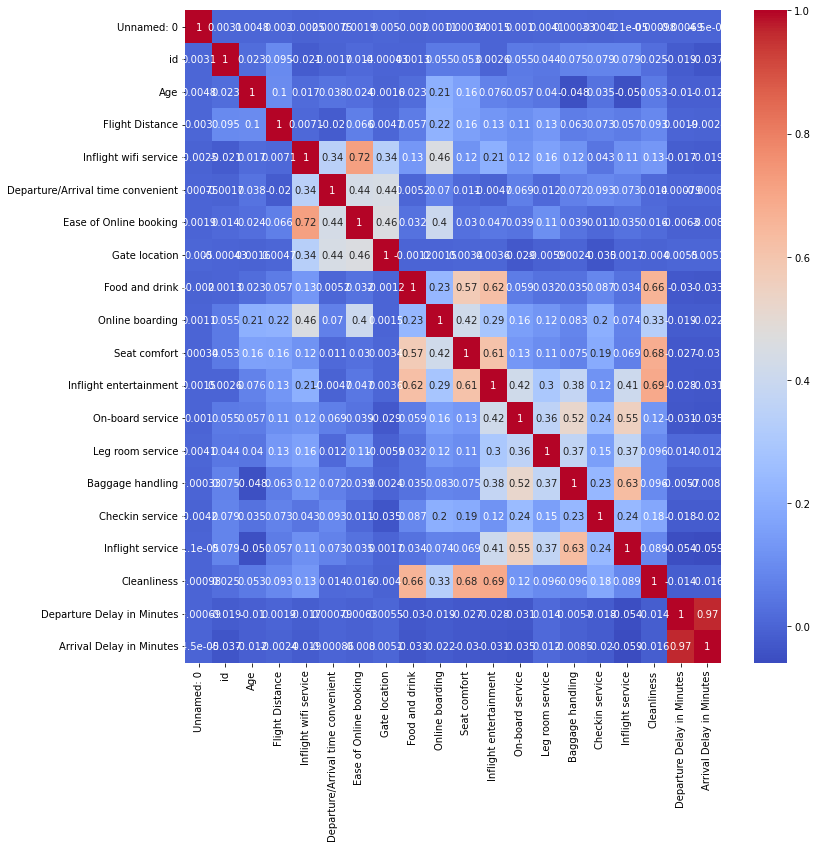

In [10]:
fig, ax = plt.subplots(figsize=(12, 12))

# Create heatmap of the correlation matrix
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', ax=ax)
plt.show()

If we set a cutoff point of 0.3 for the correlation coefficient, we can see that column Unnamed:0, id, Age, Flight Distance and Checkin service does not have any correlation coefficients higher than 0.3, indicating that these 3 variables are highly independent from other variables and should be excluded from our analysis.

In [11]:
#Exclude catagorical variables, id and low correlated numeric variables
df = df.loc[:, ~df.columns.isin(['Gender', 'Customer Type', 'Type of Travel', 'Class', 'id', 'Unnamed: 0', 'Age', 'Flight Distance', 'Checkin service'])]

<a id="153"></a> <br>
### C. Standardize the data

In [12]:
df.loc[:, ~df.columns.isin(['satisfaction'])].head()

,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes
0,3,4,3,1,5,3,5,5,4,3,4,5,5,25,18.0
1,3,2,3,3,1,3,1,1,1,5,3,4,1,1,6.0
2,2,2,2,2,5,5,5,5,4,3,4,4,5,0,0.0
3,2,5,5,5,2,2,2,2,2,5,3,4,2,11,9.0
4,3,3,3,3,4,5,5,3,3,4,4,3,3,0,0.0


In [13]:
#Only keep numeric variables
x = df.loc[:, ~df.columns.isin(['satisfaction'])].values
x

array([[ 3.,  4.,  3., ...,  5., 25., 18.],
       [ 3.,  2.,  3., ...,  1.,  1.,  6.],
       [ 2.,  2.,  2., ...,  5.,  0.,  0.],
       ...,
       [ 1.,  1.,  1., ...,  4.,  7., 14.],
       [ 1.,  1.,  1., ...,  1.,  0.,  0.],
       [ 1.,  3.,  3., ...,  1.,  0.,  0.]])

In [14]:
x = StandardScaler().fit_transform(x)

In [15]:
y = df.loc[:,['satisfaction']].values
y

array([['neutral or dissatisfied'],
       ['neutral or dissatisfied'],
       ['satisfied'],
       ...,
       ['neutral or dissatisfied'],
       ['neutral or dissatisfied'],
       ['neutral or dissatisfied']], dtype=object)

In [16]:
features = df.columns[0:15]
features

Index(['Inflight wifi service', 'Departure/Arrival time convenient',
       'Ease of Online booking', 'Gate location', 'Food and drink',
       'Online boarding', 'Seat comfort', 'Inflight entertainment',
       'On-board service', 'Leg room service', 'Baggage handling',
       'Inflight service', 'Cleanliness', 'Departure Delay in Minutes',
       'Arrival Delay in Minutes'],
      dtype='object')

In [17]:
df_scale = pd.DataFrame(data = x, columns = features)
df_scale.head()

,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,Food and drink,Online boarding,Seat comfort,Inflight entertainment,On-board service,Leg room service,Baggage handling,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes
0,0.203521,0.616249,0.173716,-1.547312,1.352401,-0.185632,1.182991,1.231530,0.479237,-0.267143,0.311853,1.156211,1.305913,0.268966,0.072905
1,0.203521,-0.695032,0.173716,0.017981,-1.656487,-0.185632,-1.849863,-1.769166,-1.849452,1.253304,-0.534854,0.305580,-1.742432,-0.360682,-0.237184
2,-0.549571,-0.695032,-0.541118,-0.764666,1.352401,1.296479,1.182991,1.231530,0.479237,-0.267143,0.311853,0.305580,1.305913,-0.386917,-0.392229
3,-0.549571,1.271890,1.603383,1.583273,-0.904265,-0.926688,-1.091649,-1.018992,-1.073222,1.253304,-0.534854,0.305580,-0.980345,-0.098328,-0.159662
4,0.203521,-0.039391,0.173716,0.017981,0.600179,1.296479,1.182991,-0.268818,-0.296993,0.493081,0.311853,-0.545051,-0.218259,-0.386917,-0.392229


<a id="16"></a> <br>
## 6. Factor Analysis

<a id="161"></a> <br>
### A. Use Screeplot to determine number of factors

In [18]:
fa = FactorAnalyzer(n_factors=16, rotation="varimax") #Use varimax to increase interpretation
fa.fit(df_scale)

FactorAnalyzer(n_factors=16, rotation='varimax', rotation_kwargs={})

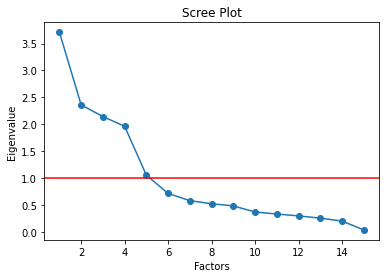

In [19]:
ev, v = fa.get_eigenvalues()
plt.plot(range(1, 16), ev[:15], marker='o') 
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.axhline(y=1, color='r', linestyle='-')
plt.show()

5 factors are suggested from Scree plot.

<a id="162"></a> <br>
### B. Factor analysis with 5 factors

In [20]:
fa = FactorAnalyzer(n_factors=5, rotation="varimax")
fa.fit(df_scale)

FactorAnalyzer(n_factors=5, rotation='varimax', rotation_kwargs={})

In [21]:
loadings = pd.DataFrame(fa.loadings_, index=df_scale.columns)
loadings = loadings.rename(columns={0: 'Factor 1', 1: 'Factor 2', 2: 'Factor 3', 3: 'Factor 4', 4: 'Factor 5'})
loadings

,Factor 1,Factor 2,Factor 3,Factor 4,Factor 5
Inflight wifi service,0.090932,0.133234,-0.010398,0.483892,0.623059
Departure/Arrival time convenient,-0.010304,0.054888,-0.000058,0.602024,0.087468
Ease of Online booking,-0.040320,0.030189,-0.003142,0.645227,0.626126
Gate location,0.004729,-0.033380,0.004474,0.713676,0.006543
Food and drink,0.765687,-0.006267,-0.018718,0.030156,0.042977
Online boarding,0.307542,0.088762,-0.009237,-0.007077,0.680321
Seat comfort,0.761438,0.054598,-0.013430,-0.043699,0.179048
Inflight entertainment,0.773511,0.469869,-0.009175,0.020124,0.060684
On-board service,0.099558,0.690874,-0.021339,-0.006980,0.063193
Leg room service,0.063689,0.482470,0.022840,0.005416,0.124565


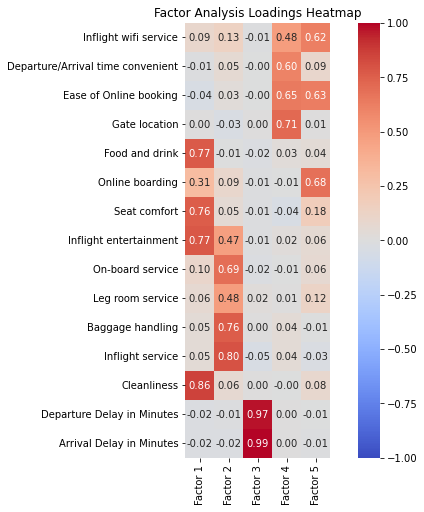

In [22]:
plt.figure(figsize=(10, 8))
sns.heatmap(loadings, cmap='coolwarm', annot=True, fmt='.2f', center=0, vmin=-1, vmax=1, square=True)
plt.title('Factor Analysis Loadings Heatmap')
plt.show()

Varimax rotation produced clearer categorization for the variables. Specifically:

__In-flight experience__ (Factor 1): Cleanliness, Seat comfort, Food and drink, Inflight entertainment

__Service__ (Factor 2): Inflight service, Baggage handling, On board service

__Punctuation__ (Factor 3): Departure Delay in Minutes, Arrival Delay in Minutes

__Convenience__ (Factor 4): Gate location, Departure / Arrival time convenient, Ease of Online booking

__Technology__ (Factor 5): Ease of Online booking, Online boarding and Inflight wifi service

<a id="17"></a> <br>
## 7. Splitting Data into Training and Test Sets
Use 30% testing dataset to evaluate the accuracy of logistics regression, LDA and random forest.

In [23]:
X_train, X_test, y_train, y_test = train_test_split(x, 
                                                    y, 
                                                    test_size=0.30, 
                                                    random_state=101)

In [24]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(72515, 15)
(72515, 1)
(31079, 15)
(31079, 1)


<a id="18"></a> <br>
## 8. Logistic regression (with using PCA pre-processing)

<a id="181"></a> <br>
### A. Apply PCA

In [25]:
pca = PCA(.85) #Select number of PCAs that already capture 85% of variance

In [26]:
pca.fit(X_train)

PCA(n_components=0.85)

In [27]:
pca.n_components_

8

Apply the mapping (transform) to both the training set and the test set.

In [28]:
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)

<a id="182"></a> <br>
### B. Define function and use gridsearch for the best hyperparameters

In [29]:
def find_hyperparameters(cv_val: int):
    grid={"C":np.logspace(-3,3,7), "penalty":["l1","l2"], 'solver'  : ['newton-cg', 'lbfgs', 'liblinear']}# l1 lasso l2 ridge
    logreg = LogisticRegression()
    logreg_cv = GridSearchCV(logreg,grid,cv=cv_val)
    logreg_cv.fit(X_train,y_train)
    
    print("Tuned hyperparameters :(best parameters) ",logreg_cv.best_params_)
    print("Accuracy :",logreg_cv.best_score_)

In [30]:
find_hyperparameters(2)

Tuned hyperparameters :(best parameters)  {'C': 0.01, 'penalty': 'l1', 'solver': 'liblinear'}
Accuracy : 0.8106322791365037


In [31]:
logisticRegr = LogisticRegression(C=0.01, penalty = 'l1', solver= 'liblinear')

In [32]:
start_time = time.time()
logisticRegr.fit(X_train, y_train)
end_time = time.time()

In [33]:
# Predict for One Observation
logisticRegr.predict(X_test[0].reshape(1,-1))

array(['neutral or dissatisfied'], dtype=object)

In [34]:
# Predict for Multiple Observations at Once
y_pred =logisticRegr.predict(X_test)
y_pred

array(['neutral or dissatisfied', 'neutral or dissatisfied', 'satisfied',
       ..., 'neutral or dissatisfied', 'neutral or dissatisfied',
       'neutral or dissatisfied'], dtype=object)

<a id="183"></a> <br>
### C. Measuring Model Performance

In [35]:
score = logisticRegr.score(X_test, y_test)
print(score)

0.8093889764792948


In [36]:
total_time = end_time - start_time
print("Time taken: {:.2f} seconds".format(total_time))

Time taken: 0.17 seconds


<a id="184"></a> <br>
### D. Evaluation - classification accuracy

In [37]:
print(classification_report(y_test,y_pred))

                         precision    recall  f1-score   support

neutral or dissatisfied       0.82      0.85      0.83     17615
              satisfied       0.79      0.76      0.78     13464

               accuracy                           0.81     31079
              macro avg       0.81      0.80      0.80     31079
           weighted avg       0.81      0.81      0.81     31079



<a id="19"></a> <br>
## 9. Linear Discriminant Analysis (LDA)

<a id="191"></a> <br>
### A. Apply LDA

In [38]:
lda = LinearDiscriminantAnalysis(n_components=1) #2 response variables; 1 component

In [39]:
start_time = time.time()
X_lda = lda.fit_transform(X_train, y_train)
end_time = time.time()

In [40]:
# Prediction
y_pred_lda = lda.predict(X_test)
y_pred_lda

array(['neutral or dissatisfied', 'neutral or dissatisfied', 'satisfied',
       ..., 'neutral or dissatisfied', 'neutral or dissatisfied',
       'neutral or dissatisfied'], dtype='<U23')

<a id="192"></a> <br>
### B. Measuring Model Performance

In [41]:
score_lda = lda.score(X_test, y_test)
print(score_lda)

0.8071366517584221


In [42]:
total_time_lda = end_time - start_time
print("Time taken: {:.2f} seconds".format(total_time_lda))

Time taken: 0.25 seconds


<a id="193"></a> <br>
### C. Evaluation - classification accuracy

In [43]:
print(classification_report(y_test,y_pred_lda))

                         precision    recall  f1-score   support

neutral or dissatisfied       0.82      0.84      0.83     17615
              satisfied       0.78      0.77      0.78     13464

               accuracy                           0.81     31079
              macro avg       0.80      0.80      0.80     31079
           weighted avg       0.81      0.81      0.81     31079



<a id="110"></a> <br>
## 10. Random Forest

<a id="101"></a> <br>
### A. Use GridSearch to determine the optimal value of n_estimators

In [44]:
y_train_ravel = np.ravel(y_train) #convert the target variable into a 1D array to avoid warning in RandomForestClassifier

param_grid = {
    'n_estimators': [50, 100, 150, 200, 250, 300]
}

rf = RandomForestClassifier()

grid_search = GridSearchCV(
    estimator=rf, 
    param_grid=param_grid, 
    cv=5,  # number of folds for cross-validation
    scoring='accuracy',  # evaluation metric
    n_jobs=-1  # use all available processors
)

grid_search.fit(X_train, y_train_ravel)

print(f"Best parameter: {grid_search.best_params_}")
print(f"Best score: {grid_search.best_score_}")

Best parameter: {'n_estimators': 200}
Best score: 0.908846445562987


<a id="102"></a> <br>
### B. Run Random Forest

In [45]:
rf = RandomForestClassifier(n_estimators=200, random_state=123)

In [46]:
start_time = time.time()
rf.fit(X_train, y_train_ravel)
end_time = time.time()

In [47]:
# Prediction
y_pred_rf = rf.predict(X_test)

<a id="103"></a> <br>
### C. Measuring Model Performance

In [48]:
score_rf = rf.score(X_test, y_test)
print(score_rf)

0.9097461308278902


In [49]:
total_time_rf = end_time - start_time
print("Time taken: {:.2f} seconds".format(total_time_rf))

Time taken: 28.16 seconds


<a id="104"></a> <br>
### D. Evaluation - classification accuracy

In [50]:
print(classification_report(y_test,y_pred_rf))

                         precision    recall  f1-score   support

neutral or dissatisfied       0.90      0.94      0.92     17615
              satisfied       0.92      0.87      0.89     13464

               accuracy                           0.91     31079
              macro avg       0.91      0.91      0.91     31079
           weighted avg       0.91      0.91      0.91     31079



<a id="105"></a> <br>
### 5. Finding important features in Random Forest

It is common to see that the number of important features identified by rfc.feature_importances_ is less than the total number of features in the original dataset. 

In [54]:
importance_indices = rf.feature_importances_.argsort()[::-1]
important_features = df_scale.columns[importance_indices]
print(important_features)

Index(['Inflight wifi service', 'Food and drink',
       'Departure/Arrival time convenient', 'Seat comfort',
       'Inflight entertainment', 'Online boarding', 'Ease of Online booking',
       'Gate location'],
      dtype='object')


In [55]:
feature_imp = pd.Series(rf.feature_importances_,index=important_features).sort_values(ascending=False)
feature_imp

Inflight wifi service                0.302381
Inflight entertainment               0.159638
Food and drink                       0.150213
Ease of Online booking               0.095106
Gate location                        0.088669
Online boarding                      0.077167
Departure/Arrival time convenient    0.068113
Seat comfort                         0.058713
dtype: float64

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


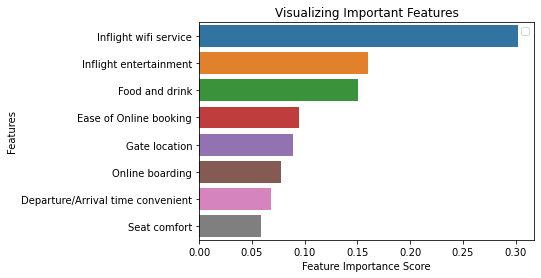

In [56]:
# Creating a bar plot
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()